In [1]:
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from tqdm import tqdm
import torch
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt
from random import randin
import seaborn as sns


2025-05-03 17:00:55.689584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746291655.832287     858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746291655.861112     858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 17:00:56.098379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds = load_dataset("Deysi/spam-detection-dataset")

Given below is the configuration of the model that we are using.

This configuration outputs probabilities for each token as its final output.

The final layer of the model (called the LM layer (LM stands for Language Model)) converts the context vector matrix into a probability distribution over the vocabulary. This is useful for predicting the next token.

However, since we are building a classifier, we dont need this layer. The context vector matrix is much more useful for our task.

While instantiating the model, if we use Automodel instead of AutoModelForCausalLM, the LM layer will not be created

The size of the context vector in the last layer is a vector in 576 dimensions

However, a binary classifier needs to output a scalar value. For that purpose, we add a layer of the dimensions 576x1 after the last layer of the model to convert the 576 dimension vector into into a scalar.

To get a value between 0 and 1, we can then apply a sigmoid function on this scalar output.

Since we are using a causal model, the context vector for a certain token only contains information about the preceding tokens.

Hence, the last context vector will contain context for all tokens. So we discard the rest and just use this.

In [3]:
config = '''LlamaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "eos_token_id": 0,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 576,
  "initializer_range": 0.041666666666666664,
  "intermediate_size": 1536,
  "is_llama_config": true,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 9,
  "num_hidden_layers": 30,
  "num_key_value_heads": 3,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_interleaved": false,
  "rope_scaling": null,
  "rope_theta": 100000,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "vocab_size": 49152
}
'''

In [4]:
class spam_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.checkpoint = "HuggingFaceTB/SmolLM2-135M"
        self.tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.basemodel = AutoModel.from_pretrained(self.checkpoint)
        self.final_layer = nn.Linear(self.basemodel.config.hidden_size, 1)

    def tokenize_function(self, examples):
        return self.tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.basemodel(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        # Mean pooling for decoder-only models
        pooled = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
        logits = self.final_layer(pooled).squeeze(-1)

        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())
            return loss, logits

        return logits


# Tokenizing
ds = ds.map(spam_classifier().tokenize_function, batched=True)

def convert_label(example):
    example["label"] = 1 if example["label"] == "spam" else 0
    return example

ds = ds.map(convert_label)


Map:   0%|          | 0/8175 [00:00<?, ? examples/s]

Map:   0%|          | 0/2725 [00:00<?, ? examples/s]

Map:   0%|          | 0/8175 [00:00<?, ? examples/s]

Map:   0%|          | 0/2725 [00:00<?, ? examples/s]

In [5]:
ds_sample = ds['test'][randint(1,1000)]

for key in ds_sample:
    print(key, ':', ds_sample[key])

text : Holla, peeps! It's yo boy from InstaGram, ready to drop some lit content on yo feed! I know y'all been waitin' for this, so without further ado, let's get crackin'!


label : 1
input_ids : [56, 35030, 28, 610, 11726, 17, 657, 506, 329, 95, 7706, 429, 2006, 81, 43889, 28, 4421, 288, 5768, 634, 1150, 2627, 335, 329, 95, 2645, 17, 339, 699, 329, 23, 449, 719, 5847, 254, 23, 327, 451, 28, 588, 1355, 2030, 493, 95, 28, 1303, 506, 820, 10540, 254, 23, 17, 1116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

⚠️ No weights file found at '/workspaces/code/sem4git/mat496/project-2.pth'.
Model initialised with random weights.


Map:   0%|          | 0/8175 [00:00<?, ? examples/s]

Map:   0%|          | 0/2725 [00:00<?, ? examples/s]

Epoch 1: 100%|██████████| 1022/1022 [08:47<00:00,  1.94it/s, loss=0.000705]


Epoch 1 complete
✅✅✅MODEL SAVED SUCCESSFULLY!!!💾💾💾


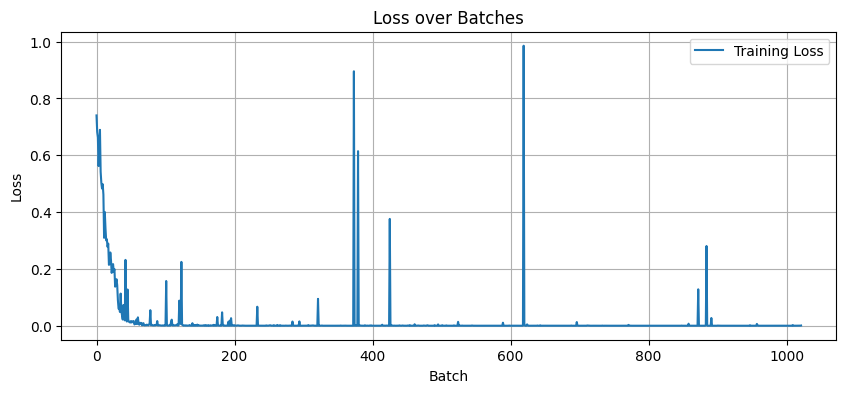

In [6]:
# Make sure model is on GPU and in correct precision

weights_path = os.path.join(os.getcwd(), "project-2.pth")

model = spam_classifier().to(device="cuda")

if os.path.isfile(weights_path):
    model.load_state_dict(torch.load(weights_path))
    print(f"✅ Loaded model weights from '{weights_path}'")
else:
    print(f"⚠️ No weights file found at '{weights_path}'.\nModel initialised with random weights.")


model.train()

# Remove "text" column if present
def remove_text(example):
    example.pop("text", None)
    return example

# Apply to dataset
ds_textrm = ds.map(remove_text)

# DataLoader
collator = DataCollatorWithPadding(tokenizer=model.tokenizer, return_tensors="pt")
train_dl = DataLoader(
    ds_textrm['train'],
    batch_size=8,
    shuffle=True,
    collate_fn=collator,
    pin_memory=True,
)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

losses = []

# Training loop
for epoch in range(1):
    loop = tqdm(train_dl, desc=f"Epoch {epoch + 1}")
    for batch in loop:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda").float()

        # Forward pass
        loss, _ = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track loss
        losses.append(loss.item())

        # Show loss in tqdm
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} complete")

torch.save(model.state_dict(), os.path.join(os.getcwd(), "project-2.pth"))
print("✅✅✅MODEL SAVED SUCCESSFULLY!!!💾💾💾")

# Plot the loss after training
plt.figure(figsize=(10, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss over Batches")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model.eval()
all_preds = []
all_labels = []
test_dl = DataLoader(ds_textrm['test'], batch_size=8, shuffle=False, collate_fn=collator, pin_memory=True)

with torch.no_grad():
    for batch in tqdm(test_dl, desc="Eval Progress", unit=" batches"): 
        input_ids = batch["input_ids"].to("cuda", non_blocking=True)
        attention_mask = batch["attention_mask"].to("cuda", non_blocking=True)
        labels = batch["labels"].to("cuda", non_blocking=True).long()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(logits).squeeze()
        preds = (preds > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Eval Progress: 100%|██████████| 341/341 [00:47<00:00,  7.19 batches/s]


Confusion Matrix:
TP: 1372 | FN: 3 | FP: 1 | TN: 1349
Accuracy: 99.85%


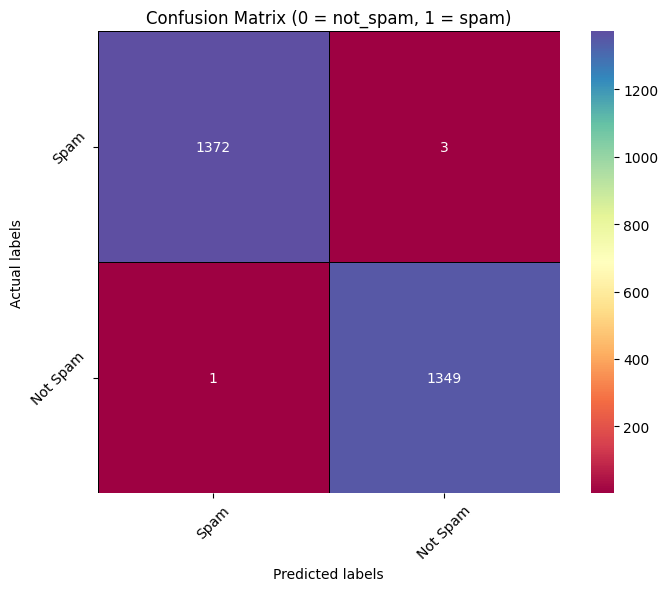

In [33]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

print("Confusion Matrix:")
print(f"TP: {tp} | FN: {fn} | FP: {fp} | TN: {tn}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn)*100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap([[tp, fn], [fp, tn]], annot=True, cmap="Spectral", fmt="d", 
            xticklabels=["Spam", "Not Spam"], yticklabels=["Spam", "Not Spam"],
            square=True, linewidths=0.5, linecolor="black")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Confusion Matrix (0 = not_spam, 1 = spam)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()